In [1]:
import torch
torch.set_grad_enabled(False)
import argparse
import os
import gc
import copy

from safetensors.torch import save_file
from diffusers import DiffusionPipeline

/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
torch_dtype = torch.bfloat16 # do not use bfloat16
device = 'cuda:0'

pipe = DiffusionPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", 
                                         vae=None,
                                         torch_dtype=torch_dtype, 
                                         safety_checker=None).to(device)

Keyword arguments {'safety_checker': None} are not expected by FluxPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [3]:
uce_modules = []
uce_module_names = []
for name, module in pipe.transformer.named_modules():
    if 'context_embedder' in name or 'text_embedder.linear_1' in name:
        uce_modules.append(module)
        uce_module_names.append(name)
original_modules = copy.deepcopy(uce_modules)
uce_modules = copy.deepcopy(uce_modules)


pipe.transformer=None
pipe.vae=None
torch.cuda.empty_cache()
gc.collect()

28

In [15]:
pipe.tokenizer_2(e,
                                   padding="max_length",
                                   max_length=pipe.tokenizer_2.model_max_length,
                                   return_overflowing_tokens=False,
                                   return_length=False,
                                   return_tensors="pt",
                                  )['attention_mask']

pipe.tokenizer_2.tokenize(e)

['▁image', '▁of', '▁', 'a', '▁dog']

In [23]:
e = 'dog'
pipe.tokenizer_2(e,
                   padding="max_length",
                   max_length=max_sequence_length,
                   return_overflowing_tokens=False,
                   truncation=True,
                   return_length=False,
                   return_tensors="pt",
                  )

{'input_ids': tensor([[1782,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,

In [22]:
e = 'dog'
max_sequence_length= 256
t_emb = pipe.encode_prompt(prompt=e,
                           prompt_2=None,
                           device=device,
                           num_images_per_prompt=1,
                           max_sequence_length=max_sequence_length
                           )

last_token_idx = (pipe.tokenizer_2(e,
                                   padding="max_length",
                                   max_length=max_sequence_length,
                                   return_overflowing_tokens=False,
                                   truncation=True,
                                   return_length=False,
                                   return_tensors="pt",
                                  )['attention_mask']).sum()-1
t_emb[0][0], last_token_idx

(tensor([[-0.0386,  0.0474, -0.0084,  ..., -0.1167, -0.0356, -0.0078],
         [-0.0042, -0.0102, -0.0016,  ..., -0.0105,  0.0095,  0.0043],
         [-0.1196,  0.2363, -0.1533,  ..., -0.2236, -0.0625,  0.2178],
         ...,
         [ 0.0598, -0.0112,  0.0479,  ..., -0.0015, -0.0469, -0.0206],
         [ 0.0806,  0.0327, -0.0131,  ..., -0.1104, -0.0547, -0.0466],
         [-0.0063,  0.0209, -0.0068,  ...,  0.0077, -0.0199,  0.0115]],
        device='cuda:0', dtype=torch.bfloat16),
 tensor(0))

In [12]:
erase_concepts = ['car']
guide_concepts = ['']

preserve_concepts = []
max_sequence_length = 256

uce_erase_embeds = {}
for e in erase_concepts + guide_concepts + preserve_concepts:
    if e in uce_erase_embeds:
        continue
    t_emb = pipe.encode_prompt(prompt=e,
                               prompt_2=None,
                               device=device,
                               num_images_per_prompt=1,
                               max_sequence_length=max_sequence_length
                               )

    last_token_idx = (pipe.tokenizer_2(e,
                                       padding="max_length",
                                       max_length=max_sequence_length,
                                       return_overflowing_tokens=False,
                                       truncation=True,
                                       return_length=False,
                                       return_tensors="pt",
                                      )['attention_mask']).sum()-2
    

    uce_erase_embeds[e] = [t_emb[0][:,last_token_idx,:], t_emb[1]]


uce_guide_outputs = {}
for g in guide_concepts + preserve_concepts:
    if g in uce_guide_outputs:
        continue

    t_emb = uce_erase_embeds[g]
    
    for module in original_modules:
        try:
            uce_guide_outputs[g] = uce_guide_outputs.get(g, []) + [module(t_emb[0])]
        except:
            uce_guide_outputs[g] = uce_guide_outputs.get(g, []) + [module(t_emb[1])]

In [13]:
# UCE Algorithm (variables are named according to the paper: https://arxiv.org/abs/2308.14761)
lamb = 0.28
erase_scale = 1
preserve_scale = 1
save_dir = '../uce_models' 
exp_name = 'car_flux'

if exp_name is None:
    exp_name = 'test_uce'
os.makedirs(save_dir, exist_ok=True)

for module_idx, module in enumerate(original_modules):
    # get original weight of the model
    w_old = module.weight
    
    mat1 = lamb * w_old
    mat2 = lamb * torch.eye(w_old.shape[1], device = device, dtype=torch_dtype)  

    emb_idx = 0
    if mat1.shape[-1] == 768:
        emb_idx = 1
    # Erase Concepts
    for erase_concept, guide_concept in zip(erase_concepts, guide_concepts):
        c_i = uce_erase_embeds[erase_concept][emb_idx].T
        v_i_star = uce_guide_outputs[guide_concept][module_idx].T

        mat1 += erase_scale * (v_i_star @ c_i.T)
        mat2 += erase_scale * (c_i @ c_i.T)

    # Preserve Concepts
    for preserve_concept in preserve_concepts:
        c_i = uce_erase_embeds[preserve_concept][emb_idx].T
        v_i_star = uce_guide_outputs[preserve_concept][module_idx].T

        mat1 += preserve_scale * (v_i_star @ c_i.T)
        mat2 += preserve_scale * (c_i @ c_i.T)


    uce_modules[module_idx].weight = torch.nn.Parameter(mat1 @ torch.inverse(mat2.float()).to(torch_dtype))

# save the weights
uce_state_dict = {}
for name, parameter in zip(uce_module_names, uce_modules):
    uce_state_dict[name+'.weight'] = parameter.weight
save_file(uce_state_dict, os.path.join(save_dir, exp_name+'.safetensors'))

# Evaluate UCE
## Original Model

In [6]:
pipe = None
torch.cuda.empty_cache()
gc.collect()
pipe = DiffusionPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", 
                                         torch_dtype=torch_dtype, 
                                         safety_checker=None).to(device)


Keyword arguments {'safety_checker': None} are not expected by FluxPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

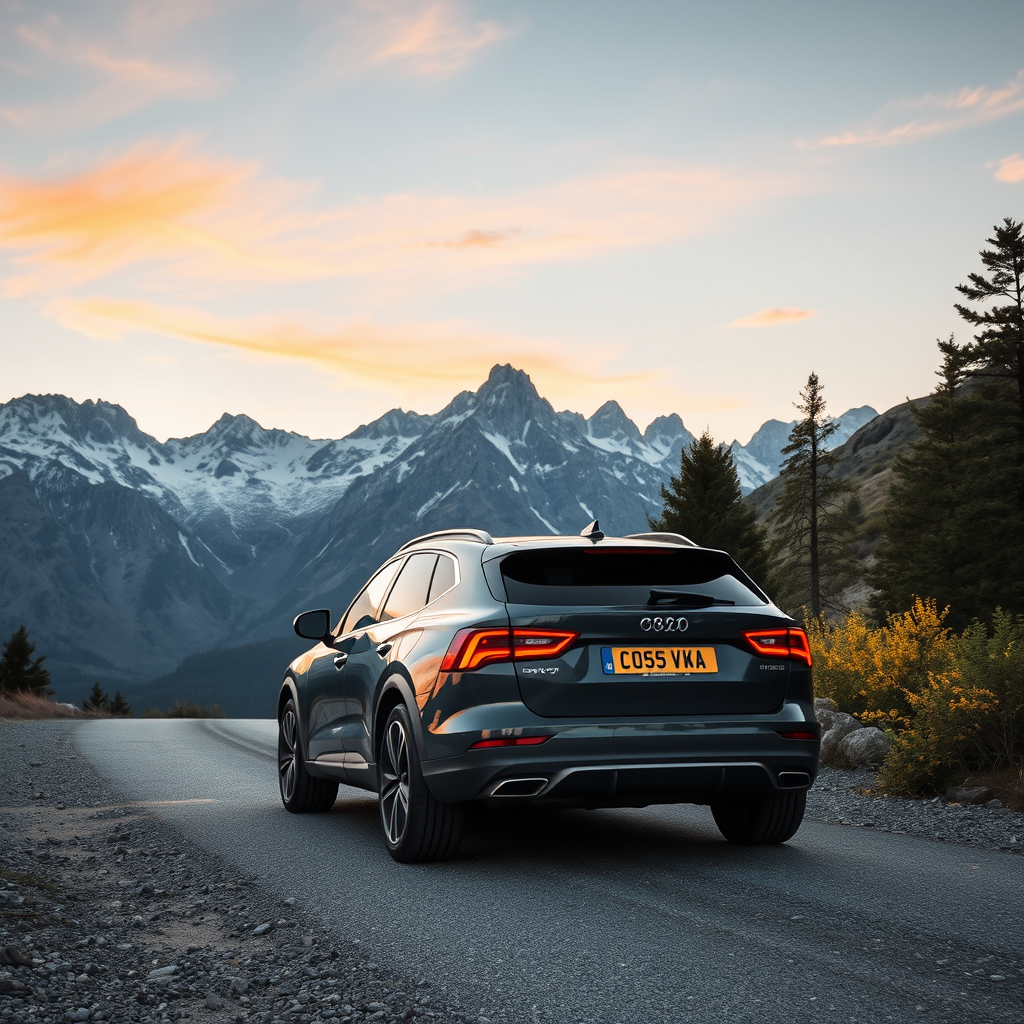

In [7]:
seed = 42
# Concept to be erased
image = pipe('image of a car in the mountain range',
             guidance_scale = 0, 
             num_inference_steps=4,
             max_sequence_length=256,
             generator=torch.Generator().manual_seed(seed)
            ).images[0]
image

# Load UCE model

In [14]:
pipe.transformer.load_state_dict(uce_state_dict, strict=False)
print('Loaded UCE Model')

Loaded UCE Model


  0%|          | 0/4 [00:00<?, ?it/s]

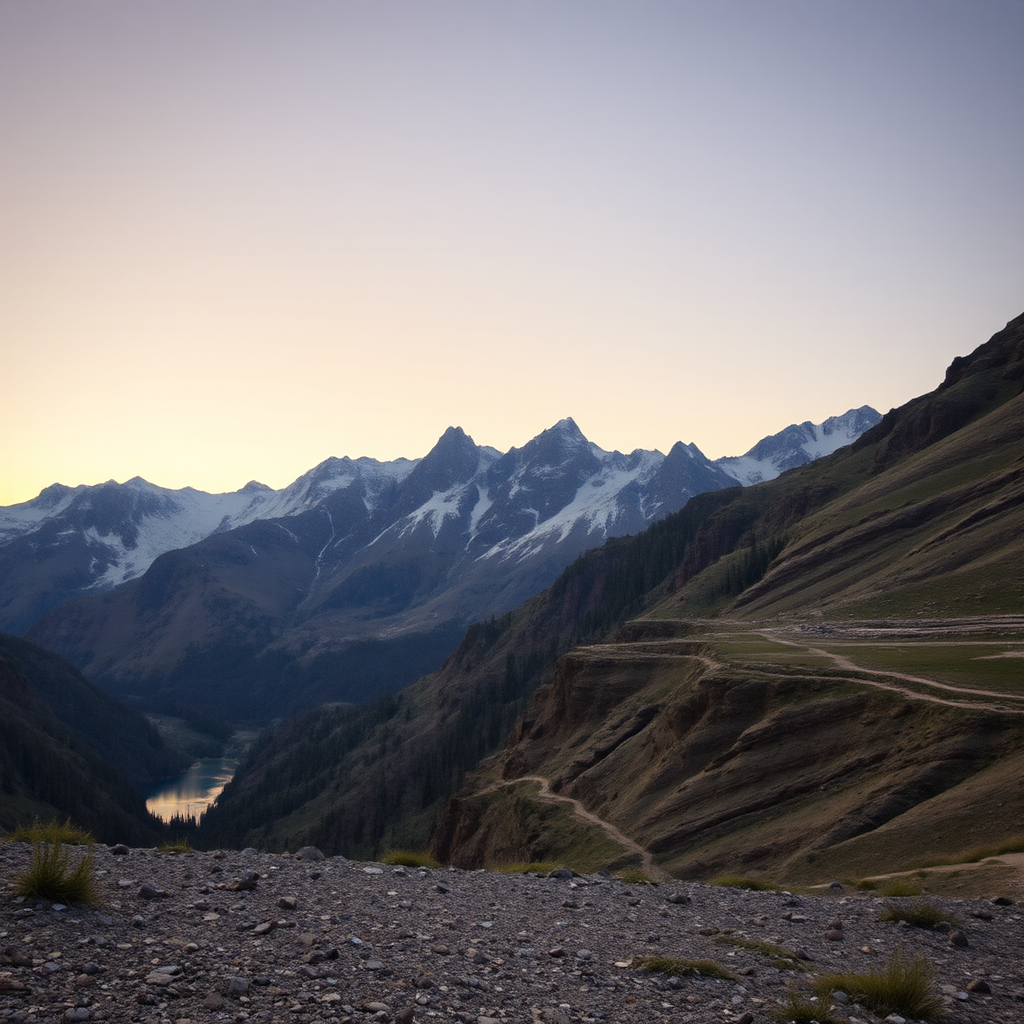

In [15]:
# Concept to be erased
seed = 42
image = pipe('image of a car in the mountain range',
             guidance_scale = 0, 
             num_inference_steps=4,
             max_sequence_length=256,
             generator=torch.Generator().manual_seed(seed)
            ).images[0]
image